# **D213 Performance Assessment 2:** Sentiment Analysis

**Student:** Chris Fischer  
**ID:** 011933891  

# Part I: Study Overview
---

## A1: Research Question

Can we develop a reusable sentiment analysis model which can determine whether a customer comment is generally positive or negative?

## A2: Objective

This study hopes to develop a model for classifying the sentiment of comments our customers submit through our feedback page. The study will produce a model using labeled customer sentiment training data from Amazon, Imdb, and Yelp. A portion of the available data will be reserved for model validation and testing to ensure the goodness of fit of the resulting model.

## A3: Method

For this study, the team will use recurrent neural network (RNN) to classify whether a textual comment is positive or negative in sentiment. In essence, this model will be a form of logistic regression because the label must either be 1 or 0, true or false. But unlike other logistic regressions, for textual analysis, the words contained in the comments each become features, making for a very complex regression. An RNN analyzes inputs much the way a human mind does, assigning weight to each work successively until an assessment is arrived at regarding the sentiment of the text.

# Part II: Data Preparation
---

## B1: EDA

Before a model can be trained using the provided datasets, several exploration and cleansing steps must occur. For our study, the following steps will be taken:
1. Import and merge the three source files (During EDA, it was discovered that some data contained extraneous quote characters which caused the intended merging of some observations. Therefore, we cleaned the quote characters out of the files prior to loading and merging.)
1. Visualize the data on a frequency chart
1. Check for non-alphabetic data and cleanse the text
    - Remove any URLs or @ tags
    - Convert to lowercase
    - Convert whole numbers (0-10) into words
    - Remove stop words
    - Remove any remaining non-alphabetic characters
1. Visualize positive and negative sentiment frequent words with word clouds


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

#### Load the files

In [52]:
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Clean double quotes from files before reading them into dataframes because it caused merging some rows (Levitsky, 2012)
def clean_quotes(input_filename):
    output_filename = f"cleaned_{input_filename}"
    
    with open(input_filename, 'r') as infile, open(output_filename, 'w') as outfile:
        for line in infile:
            cleaned_line = line.replace('"', '')
            outfile.write(cleaned_line)

clean_quotes('amazon_cells_labelled.txt')
clean_quotes('imdb_labelled.txt')
clean_quotes('yelp_labelled.txt')

# Read each file into a separate dataframe, add the site each review came from
df_amazon = pd.read_csv('cleaned_amazon_cells_labelled.txt', sep='\t', names=['text','sentiment'])
df_amazon['site'] = 'Amazon'
df_imdb = pd.read_csv('cleaned_imdb_labelled.txt', sep='\t', names=['text','sentiment'])
df_imdb['site'] = 'Imdb'
df_yelp = pd.read_csv('cleaned_yelp_labelled.txt', sep='\t', names=['text','sentiment'])
df_yelp['site'] = 'Yelp'

# Check the shape of each df
print(f'Amazon shape: {df_amazon.shape}')
print(f'Imdb shape: {df_imdb.shape}')
print(f'Yelp shape: {df_yelp.shape}')


Amazon shape: (1000, 3)
Imdb shape: (1000, 3)
Yelp shape: (1000, 3)


In [53]:
# Merge the three dataframes into one
df = pd.concat([df_amazon, df_imdb, df_yelp], ignore_index=True)
print(f'Combined shape: {df.shape}')

Combined shape: (3000, 3)


#### Plot the data

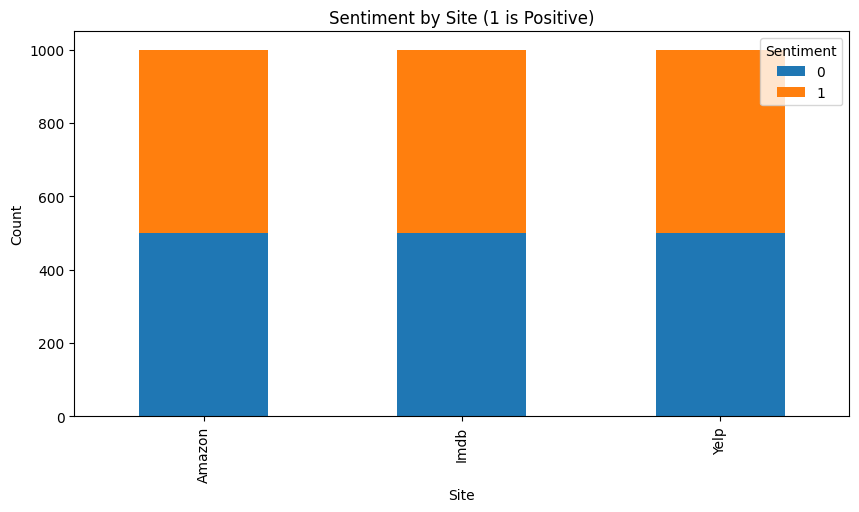

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a stacked bar chart (Bobbitt, 2022)
df.groupby(['site', 'sentiment']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('Site')
plt.ylabel('Count')
plt.title('Sentiment by Site (1 is Positive)')
plt.legend(title='Sentiment')
plt.show()

#### Check for non-alphabetic data (rubric item B1, point 1)

In [55]:
# Check for rows with anything other than letters
pattern = r'[^A-Za-z\s]'
mask = df['text'].str.contains(pattern, regex=True)
print(f"Rows with non-alphabetic characters {df.text[mask].count()}")

Rows with non-alphabetic characters 2991


A signficant percentage of the dataset contain non-alphabetic characters such as punctuation and number. These characters introduce noise to the natural language processing that will occur later in the study. Therefore, before proceeding, we will cleanse the text by:
- Removing any URLs found embedded in the text
- Remove any @ handles
- Change any occurrences of the numbers 0-10 (appearing as whole words only, not part of a larger number) into the words zero - ten
- Remove any remaining non-alphabetic characters 

#### Cleanse the text 

In [56]:
# Remove URLs (Kumar, 2023)
df['text'] = df['text'].str.replace(r'https?:\/\/.\S+', ' ', regex=True)

# Remove @tags
df['text'] = df['text'].str.replace(r'@\w+', ' ', regex=True)

# Replace numbers with words
df['text'] = df['text'].str.replace(r'\b10\b', 'ten', regex=True)
df['text'] = df['text'].str.replace(r'\b9\b', 'nine', regex=True)
df['text'] = df['text'].str.replace(r'\b8\b', 'eight', regex=True)
df['text'] = df['text'].str.replace(r'\b7\b', 'seven', regex=True)
df['text'] = df['text'].str.replace(r'\b6\b', 'six', regex=True)
df['text'] = df['text'].str.replace(r'\b5\b', 'five', regex=True)
df['text'] = df['text'].str.replace(r'\b4\b', 'four', regex=True)
df['text'] = df['text'].str.replace(r'\b4\b', 'three', regex=True)
df['text'] = df['text'].str.replace(r'\b3\b', 'two', regex=True)
df['text'] = df['text'].str.replace(r'\b2\b', 'one', regex=True)
df['text'] = df['text'].str.replace(r'\b0\b', 'zero', regex=True)

# Convert to lowercase
df['text'] = df['text'].str.lower()

# Keep only alphabetic characters
df['text'] = df['text'].str.replace('[^a-z ]+',' ',regex=True)

# Remove stopwords
try:
    nltk.data.find('tokenizers/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))

#### Vocabulary Size, Word Embedding Length, Maxiumum Sentence Length

While the rubric requests that these topics be addressed in the EDA section, I have chosen to defer determining these parameters until after the vocabulary has been simplified through lemmatization. Therefore, readers can find these covered in section B2 below.

#### Visualize word clouds

POSTIVE SENTIMENT WORDS


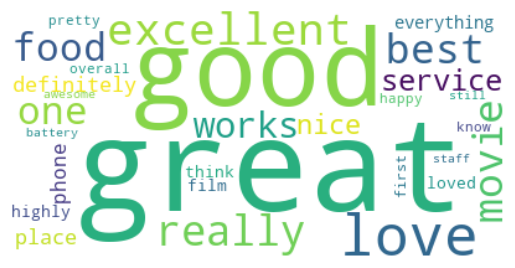

NEGATIVE SENTIMENT WORDS


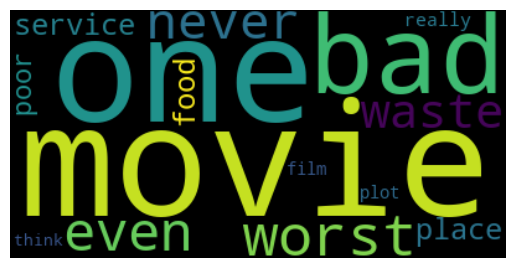

In [57]:
# Visualize word clouds for positive and negative reviews (Shah, 2021)
import wordcloud

words_negative = " ".join(neg.split()[0] for neg in df['text'][df['sentiment']==0].values if neg.split())
words_positive = " ".join(pos.split()[0] for pos in df['text'][df['sentiment']==1].values if pos.split())

wc = wordcloud.WordCloud(background_color ='white', min_font_size = 10).generate(text=words_positive)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
print("POSTIVE SENTIMENT WORDS")
plt.show()

wc = wordcloud.WordCloud(background_color ='black', min_font_size = 10).generate(text=words_negative)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
print("NEGATIVE SENTIMENT WORDS")
plt.show()


## B2: Tokenization and Sequencing

The tokenization process transforms sentence strings into lists of individual words. The words become, in essence, individual features in our analysis. In this phase, we will also use a normalization technique called lemmatization to reduce words to common roots. This will both simplify our model by reducing the number of features and improve the weighting of similar words to better capture their impact on sentiment. (Pykes, 2023)

The steps to be undertaken in this phase include:

1. Simplify the vocabulary via lemmatization
1. Identify vocabulary size
1. Identify the maximum sentence length
1. Tokenize the texts and save in the dataframe
1. Compute recommended embedding length
1. Convert the texts into numerical vectors

#### Reduce to root words with lemmatization

In [58]:
# Reduce to root words using lemmatization (Prabhakaran, 2018)
try:
    nltk.data.find('tokenizers/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#### Determine vocabulary size (rubric item B1, point 2)

In [59]:
# Determine vocabulary size (Margaret, 2024)
words = df['text'].str.split()
# Flatten the list of words
words_flat = [word for sublist in words for word in sublist]
# Count the distinct words
vocab_size = len(set(words_flat)) + 1
print(f'Number of distinct words: {vocab_size}')

Number of distinct words: 4561


#### Identify max sentence length and embedding length (rubric item B1, point 3 and 4)

Later steps in building an RNN model require knowing the length of the longest sentence in the training data, measured in words. Also, since we will be using a Keras embedding layer in our model to reduce the high dimensionality of the data, we will need to determine the output dimensions of that embedding. A good rule-of-thumb for selecting an embedded dimension size is to take the fourth root of the vocabulary size. (Google, 2017)

In [60]:
# Maximum sentence length
max_text_len = max(len(text.split()) for text in df['text'])
print(f"Maximum number of words in a single entry: {max_text_len}")

# Embedding length (Google, 2017)
embed_dim = int(round(vocab_size ** 0.25,0))
print(f"Embedded dimension: {embed_dim}")

Maximum number of words in a single entry: 44
Embedded dimension: 8


#### Tokenization and Sequencing

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

## B3: Padding

Padding in the process of adding extra elements to the text sequences just generated to ensure that each observation has the same size and shape. All neural networks, including the RNN we are using in this study, require such uniformity. We will be using "post" padding, meaning the extra zero values will be added to the end of each sequence. There is no performance difference between pre and post padding. We have chose post padding simply for better readability should an analyst examine the resulting sequences. (Shrestha, 2020)

In [62]:
# Examine one observation before padding
print(f'Before padding: {sequences[0]}')

# Apply padding
padded_sequences = pad_sequences(sequences, maxlen = max_text_len, padding='post')

# Examine same observation after padding
print(f'After padding: {padded_sequences[0]}')

Before padding: [42, 244, 98, 465, 22, 2011]
After padding: [  42  244   98  465   22 2011    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## B4: Sentiment Analysis

Our study has only two categories of sentiment: positive or negative. This makes our classification binary in nature with just two possible outcomes. Given this, we have selected the sigmoid activation function for our output layer as there will only be two possible results, 0 or 1. (Prosise, 2021)

## B5: Final Data Preparation

In our study, we have a relatively small dataset for training and testing purposes. If we had more data, we would choose a fairly standard 80%/20% split for train and test. However, given that we only have ~3,000 observations rather than risk overfitting the model, we will choose a larger test set. Therefore, we select a 70%/30% split, preserving an equal proportion of positive and negative sentiments in each set. Additionally, we will allow Keras to use 20% of our training data for validation. 

In [63]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'].values, test_size=0.3, random_state=5470, stratify=df['sentiment'])
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## B6: Output Prepared Data File

In [64]:
# Save prepared file
df.to_csv('sentiment_prepared.csv')

# Part III: Network Architecture
---

## C1: Neural Network

The team experimented with several network architectures. The one below yielded the best combination of accuracy and performance. This architecture increases the embedded dimension size signficantly from the value of 8 suggested by the fourth root heuristic.

In [65]:
# Create the model
model = Sequential([
    layers.Embedding(input_dim=vocab_size,output_dim=64),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early = EarlyStopping(monitor='val_accuracy',patience=2)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early])

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5334 - loss: 0.6905 - val_accuracy: 0.5167 - val_loss: 0.6726
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6742 - loss: 0.6134 - val_accuracy: 0.7452 - val_loss: 0.5487
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9234 - loss: 0.2920 - val_accuracy: 0.7929 - val_loss: 0.4909
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9556 - loss: 0.1324 - val_accuracy: 0.8000 - val_loss: 0.5017
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9789 - loss: 0.0776 - val_accuracy: 0.7976 - val_loss: 0.5679
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9869 - loss: 0.0536 - val_accuracy: 0.8000 - val_loss: 0.6503


#### Model Summary

In [66]:
print(model.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 44, 64)         │       291,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,381 (3.64 MB)

 Trainable params: 317,793 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 635,588 (2.42 MB)

None


## C2 and C3: Discussion

This neural network model is structured for a text-based classification task. The layers of the model include:

- An Embedding layer, which transforms the input tokens into vectors of size 64, based on a vocabulary of 4,561 tokens. This has the effect of reducing the dimensionality of the input data. No activation function is used on an Embedding layer. (Zvornicanin, 2023)
- A Bidirectional LSTM layer processes these sequences, enhancing the model's ability to understand sequential dependencies by allowing the model to consider both past and future contexts. It outputs 32-dimensional vectors. (Taparia, 2023)
- A Dense layer with 16 units aids in reducing the dimensionality from the previous layer, using ReLU activation for introducing non-linearity. (Kaplan, 2024)
- A final Dense layer that outputs a single value with sigmoid activation, which is ideal for binary classification tasks.

In total, the model comprises 953,381 parameters, of which 317,793 are trainable.

The model was compiled using binary_crossentropy for the loss function. This is the ideal loss function for binary labels. (Sorokin, 2024) The model is optimized with the adam algorithm. Adam is widely used in deep learning because of its adaptive learning rates, which adjust for each parameter. (Jamhuri, 2023)

The model was fitted with up to 50 epochs. However, an early stopping callback was used which would stop further training once there had been no material improvement to the validation accuracy metric in the last two epochs.Validation accuracy is a good metric to use as it measures the incremental improvement in the model's prediction performance on unseen data with each epoch.

# Part IV: Model Evaluation
---

## D1: Impact of Stopping Criteria

Using the early stopping criteria of validation accuracy over a patience level of 2, fitting was stopped after 6 epochs. This provided two benefits:
1. Reduce risk of overfitting the model to the training data while still maximizing validation accuracy
2. Significant savings in compute resources by iterating over 6 epochs rather than 50

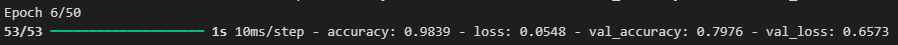

## D2: Model Accuracy

The model developed excellent accuracy with over 0.98 in the training set and over 0.79 in the validation set. The high validation accuracy gives confidence that the model is not overfit. If the model were overfit, we would expect to see very high training accuracy and much lower validation accuracy.

## D3: Visualize the Training Process

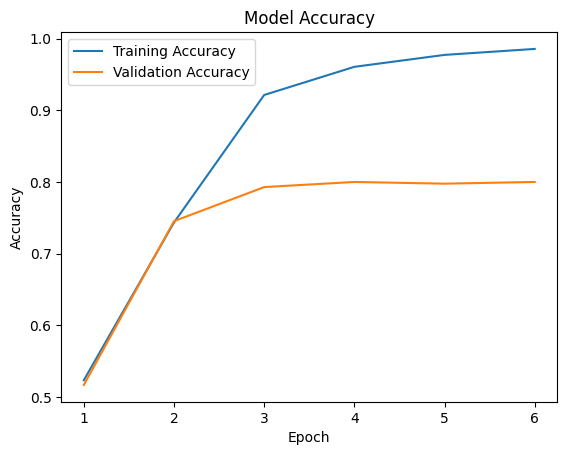

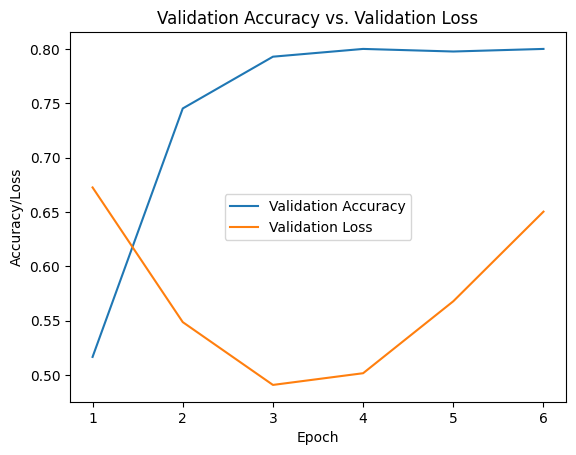

In [67]:
# Plot accuracy and val_accuracy across epochs
epochs = range(1, len(history.history['accuracy']) + 1) 
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

## D4: Predictive Accuracy

In [68]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7682 - loss: 0.8074
Test Accuracy: 0.7822222113609314
Test Loss: 0.7919090390205383


The model delivered a very respectable 0.78 accuracy on the test dataset. However, the loss metric increased somewhat to 0.77, from 0.66. This should be considered a moderate level of loss when using the binary_crossentropy loss function. (Analytics Vidhya, 2020)

# Part V: Recommendations
---

## E: Save Model

In [69]:
model.save('sentiment_model.keras')

## F: Functionality of Neural Network

The model built in this study comprises a simple, four-layer neural network. The model produces nearly 80% accurate predictions of the sentiment of free form text comments entered by customers. A simpler network architecture improves performance and will allow the model to run on very large datasets without requiring GPU-based compute resources. (Triarna, 2024)

## G: Recommendations

With a reasonably high accuracy of almost 80%, this model could be put into use immediately. However, given the quite small dataset upon which it is based, the team recommends retraining the model on a much larger set of labeled data. Many such datasets are publically available. Here is one such example: https://huggingface.co/datasets/mrshu/amazonreviews. This dataset contains 3.6 million rows of labeled Amazon customer reviews. Additionally, more time could be invested in experimenting with different network architectures. For instance, deeper and narrower architectures could be compared against wider and narrower to identify which architecture provides the highest accuracy and the lowest loss without overfitting the training data.

# Part VI: Reporting
---

## H: Industry-relevant Development Environment

This report was produced using only Jupyter Notebook in Visual Studio Code with the output converted to PDF for easier consumption by reviewers.

## I and J: List and Acknowledge Sources

All sources used for code and narrative are referenced above with in-text citations. Here is the complete list of sources used:

- Analytics Vidhya. (2020, December 30). Cross Entropy : A simple way to understand the concept | Analytics Vidhya. Medium. https://medium.com/analytics-vidhya/cross-entropy-fca0c6ea5006
- Bobbitt, Z. (2022, July 21). How to Create a Stacked Bar Chart in Pandas. Statology. https://www.statology.org/pandas-stacked-bar-chart/
- Google. (2017, November 20). Introducing TensorFlow Feature Columns. Google for Developers. https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/
- Jamhuri, M. (2023, April 15). Understanding the Adam Optimization Algorithm: A Deep Dive into the Formulas. Medium; Medium. https://jamhuri.medium.com/understanding-the-adam-optimization-algorithm-a-deep-dive-into-the-formulas-3ac5fc5b7cd3
- Kaplan, S. (2024, February 22). Dense Layer: The Building Block To Neural Networks» EML. EML. https://enjoymachinelearning.com/blog/dense-layer/
- Kumar, S. (2023, April 23). How to Remove URLs from Text in Python - Glasshost - Medium. Medium. https://medium.com/@glasshost/how-to-remove-urls-from-text-in-python-30273a4f0918
- Levitsky, L. (2012, June 23). Removing quotes from a text file in python. Stack Overflow. https://stackoverflow.com/questions/11166698/removing-quotes-from-a-text-file-in-python
- Margaret, D. (2024, August 6). Counting Distinct Words in Pandas Data Frame - DNMTechs - Sharing and Storing Technology Knowledge. DNMTechs - Sharing and Storing Technology Knowledge. https://dnmtechs.com/counting-distinct-words-in-pandas-data-frame/
- Prabhakaran, S. (2018, October 2). Lemmatization Approaches with Examples in Python. Machine Learning Plus. https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
- Prosise, J. (2021, September 21). Binary Classification with Neural Networks. Atmosera. https://www.atmosera.com/blog/binary-classification-with-neural-networks/
- Pykes, K. (2023, February). Stemming and Lemmatization in Python. Www.datacamp.com. https://www.datacamp.com/tutorial/stemming-lemmatization-python
- Shah, R. (2021, May 20). Word Cloud in Python | How to Build Word Cloud in Python? Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/
- Shrestha, S. (2020, July 7). NLP: Preparing text for deep learning model using TensorFlow2. Towards Data Science. https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657
- Sorokin, M. (2024, January 17). Binary Cross-Entropy: Mathematical Insights and Python Implementation. Medium. https://medium.com/@vergotten/binary-cross-entropy-mathematical-insights-and-python-implementation-31e5a4df78f3
- Taparia, A. (2023, June 8). Bidirectional LSTM in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/
- Triarna, A. (2024, February 15). How to Decide Neural Network Architecture? GeeksforGeeks. https://www.geeksforgeeks.org/how-to-decide-neural-network-architecture/
- Zvornicanin, E. (2023, January 5). What Are Embedding Layers in Neural Networks? Baeldung on Computer Science. https://www.baeldung.com/cs/neural-nets-embedding-layers